In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
from os.path import join
import matplotlib.pyplot as plt
from glob import glob
from keras.models import load_model
from matplotlib.colors import LogNorm
from scipy.ndimage import gaussian_filter, maximum_filter, minimum_filter
from deepsky.gan import unnormalize_multivariate_data
from skimage.morphology import disk
import pickle

Using TensorFlow backend.


In [2]:
data_path = "/glade/work/dgagne/spatial_storm_results_20171220/"
#data_path = "/Users/dgagne/data/spatial_storm_results_20171220/"

In [3]:
scores = ["auc", "bss"]
models = ["conv_net", "logistic_mean", "logistic_pca"]
imp_scores = {}
for model in models:
    imp_scores[model] = {}
    for score in scores:
        score_files = sorted(glob(data_path + "var_importance_{0}_{1}_*.csv".format(model, score)))
        imp_score_list = []
        for score_file in score_files:
            print(score_file)
            imp_data = pd.read_csv(score_file, index_col="Index")
            imp_score_list.append(((imp_data.iloc[0,0] - imp_data.loc[1:])).mean(axis=0))
        imp_scores[model][score] = pd.concat(imp_score_list, axis=1).T
        imp_scores[model][score].columns = imp_scores[model][score].columns.str.rstrip("_prev"
                                                                    ).str.replace("_", " "
                                                                    ).str.replace("-component of", ""
                                                                    ).str.replace("dew point temperature", "dewpoint"
                                                                    ).str.capitalize()

/glade/work/dgagne/spatial_storm_results_20171220/var_importance_conv_net_auc_000.csv
/glade/work/dgagne/spatial_storm_results_20171220/var_importance_conv_net_auc_001.csv
/glade/work/dgagne/spatial_storm_results_20171220/var_importance_conv_net_auc_002.csv
/glade/work/dgagne/spatial_storm_results_20171220/var_importance_conv_net_auc_003.csv
/glade/work/dgagne/spatial_storm_results_20171220/var_importance_conv_net_auc_004.csv
/glade/work/dgagne/spatial_storm_results_20171220/var_importance_conv_net_auc_005.csv
/glade/work/dgagne/spatial_storm_results_20171220/var_importance_conv_net_auc_006.csv
/glade/work/dgagne/spatial_storm_results_20171220/var_importance_conv_net_auc_007.csv
/glade/work/dgagne/spatial_storm_results_20171220/var_importance_conv_net_auc_008.csv
/glade/work/dgagne/spatial_storm_results_20171220/var_importance_conv_net_auc_009.csv
/glade/work/dgagne/spatial_storm_results_20171220/var_importance_conv_net_auc_010.csv
/glade/work/dgagne/spatial_storm_results_20171220/var_

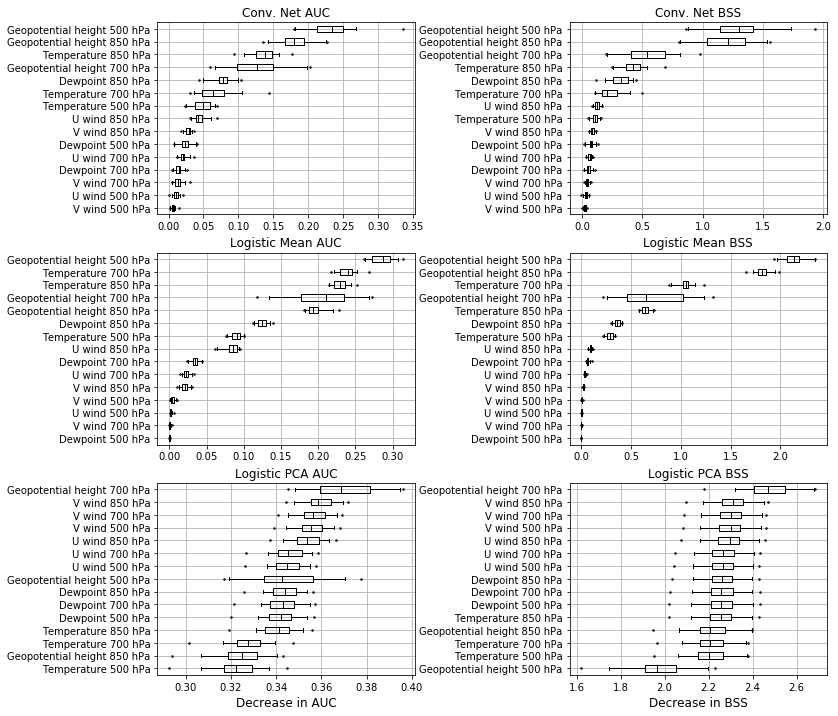

In [7]:
fig, axes = plt.subplots(3, 2, figsize=(12, 12))
plt.subplots_adjust(wspace=0.6)
model_titles = ["Conv. Net", "Logistic Mean", "Logistic PCA"]
for m, model in enumerate(models):
    for s, score in enumerate(scores):
        rankings = imp_scores[model][score].mean(axis=0).sort_values().index
        axes[m,s ].boxplot(imp_scores[model][score].loc[:, rankings].values, vert=False, 
                         boxprops={"color":"k"}, whiskerprops={"color":"k"}, 
                         medianprops={"color":"k"}, flierprops={"marker":".", "markersize":3},whis=[2.5, 97.5])
        axes[m, s].set_yticklabels(imp_scores[model][score].loc[:, rankings].columns.str.replace(" mb", " hPa"))
        axes[m, s].set_title(model_titles[m] + " " + score.upper())
        axes[m, s].grid()
        #axes[m, s].set_xscale("log")
        if m == len(model_titles) - 1:
            axes[m, s].set_xlabel("Decrease in " + score.upper(), fontsize=12)
plt.savefig("var_imp_box.pdf", dpi=300, bbox_inches="tight")

In [60]:
input_cols = imp_scores[model][score].columns

In [43]:
log_pca_coefs = np.zeros((30, 75))
for i in range(30):
    with open("/Users/dgagne/data/spatial_storm_results_20171220/" + "hail_logistic_pca_sample_{0:03d}.pkl".format(i), "rb") as pca_pkl:
        log_pca_model = pickle.load(pca_pkl)
    log_pca_coefs[i] = log_pca_model.model.coef_

In [85]:
log_gan_coefs = np.zeros((30, 64))
for i in range(30):
    with open("/Users/dgagne/data/spatial_storm_results_20171220/" + "logistic_gan_{0:d}_logistic.pkl".format(i), "rb") as gan_pkl:
        log_gan_model = pickle.load(gan_pkl)
    log_gan_coefs[i] = log_gan_model.coef_.ravel()

{'whiskers': [<matplotlib.lines.Line2D at 0x1c2feba518>,
 'caps': [<matplotlib.lines.Line2D at 0x1c2febadd8>,
 'boxes': [<matplotlib.lines.Line2D at 0x1c2feba3c8>,
 'medians': [<matplotlib.lines.Line2D at 0x1c2fec3668>,
 'fliers': [<matplotlib.lines.Line2D at 0x1c2fec3a90>,
 'means': []}

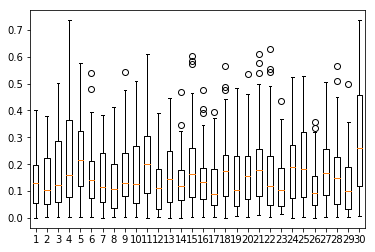

In [93]:
plt.boxplot(np.abs(log_gan_coefs.T))

In [77]:
np.abs(log_pca_coefs).min()

0.0

([<matplotlib.axis.YTick at 0x1c2e8edf60>,
 <a list of 15 Text yticklabel objects>)

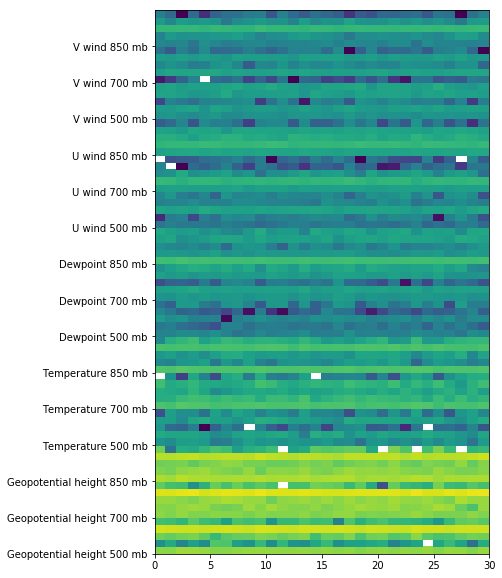

In [62]:
plt.figure(figsize=(6, 10))
plt.pcolormesh(np.abs(log_pca_coefs).T, norm=LogNorm(0.0001, 1))
plt.yticks(np.arange(0, 75, 5), input_cols)

([<matplotlib.axis.YTick at 0x1c2e2d6518>,
 <a list of 15 Text yticklabel objects>)

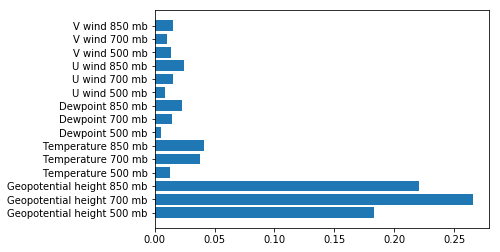

In [73]:
plt.barh(np.arange(15), np.abs(log_pca_coefs).mean(axis=0).reshape(15, 5).mean(axis=1))
plt.yticks(np.arange(15), input_cols)

In [137]:
mean_imp_matrix = pd.DataFrame(index=imp_scores["conv_net"]["bss"].columns, columns=models, dtype=float)
mean_imp_rank_matrix = pd.DataFrame(index=imp_scores["conv_net"]["bss"].columns, columns=models, dtype=int)
for model in models:
    mean_imp_matrix.loc[:, model] = imp_scores[model]["bss"].values.mean(axis=0)
    rank = np.argsort(imp_scores[model]["bss"].values.mean(axis=0))
    for r in range(rank.size):
        mean_imp_rank_matrix.loc[mean_imp_rank_matrix.index[rank[r]], model] = rank.size - r


In [93]:
mean_imp_matrix["conv_net"].values[np.argsort(mean_imp_matrix["conv_net"].values)]

array([  0.68831654,   1.13451656,   1.44212821,   1.55460714,
         2.2877488 ,   2.57388041,   3.05342006,   4.78460331,
         5.16755414,   7.18191937,   8.33550156,  13.72857337,
        14.8664198 ,  19.72752819,  25.62117955])

In [138]:
mean_imp_rank_matrix

,conv_net,logistic_mean,logistic_gan,logistic_pca
geopotential height 500 mb,1,1,14,15
geopotential height 700 mb,3,4,15,1
geopotential height 850 mb,2,2,13,12
temperature 500 mb,8,7,3,14
temperature 700 mb,6,3,12,13
temperature 850 mb,4,5,7,11
dew point 500 mb,10,15,6,10
dew point 700 mb,12,9,10,9
dew point 850 mb,5,6,2,8
u wind 500 mb,14,13,11,7
